In [1]:
# %pip install pandas
# %pip install numpy
# %pip install scikit-learn
# %pip install kagglehub
# %pip install cupy

In [2]:
import pandas as pd
import numpy as np
import kagglehub
import cupy as cp


c:\Users\patry\anaconda3\envs\weather\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
historical_hourly_weather_data_path = kagglehub.dataset_download('selfishgene/historical-hourly-weather-data')

city_attributes = pd.read_csv(f"{historical_hourly_weather_data_path}/city_attributes.csv")
humidity = pd.read_csv(f"{historical_hourly_weather_data_path}/humidity.csv")
pressure = pd.read_csv(f"{historical_hourly_weather_data_path}/pressure.csv")
temperature = pd.read_csv(f"{historical_hourly_weather_data_path}/temperature.csv")
weather_description = pd.read_csv(f"{historical_hourly_weather_data_path}/weather_description.csv")
wind_speed = pd.read_csv(f"{historical_hourly_weather_data_path}/wind_speed.csv")
wind_direction = pd.read_csv(f"{historical_hourly_weather_data_path}/wind_direction.csv")

data_frames = []
for city in city_attributes['City']:
    city_data = pd.DataFrame({
        'datetime': pd.to_datetime(humidity['datetime']),
        'humidity': humidity[city],
        'pressure': pressure[city],
        'temperature': temperature[city],
        'weather_description': weather_description[city],
        'wind_speed': wind_speed[city],
        'wind_direction': wind_direction[city],
        'latitude': city_attributes.loc[city_attributes['City'] == city, 'Latitude'].values[0],
        'longitude': city_attributes.loc[city_attributes['City'] == city, 'Longitude'].values[0],
        'city': city
    })
    city_data.set_index('datetime', inplace=True)
    data_frames.append(city_data)

combined_data = pd.concat(data_frames)

combined_data = combined_data.ffill().bfill().interpolate()

aggregated_data = combined_data.groupby(['city']).resample('D').agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': ['max', 'mean'],
    'pressure': 'mean',
    'weather_description': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'wind_direction': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

aggregated_data.columns = [
    '_'.join(col).strip('_') if isinstance(col, tuple) else col for col in aggregated_data.columns
]

C:\Users\patry\AppData\Local\Temp\ipykernel_65096\263827200.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_data = combined_data.ffill().bfill().interpolate()


In [4]:
one_hot_weather_description = pd.get_dummies(
    aggregated_data['weather_description_<lambda>'],
    prefix='weather_desc',
    drop_first=False
)

aggregated_data = pd.concat([aggregated_data, one_hot_weather_description], axis=1)
aggregated_data.drop(columns=['weather_description_<lambda>'], inplace=True)

In [5]:
binary_output = False # True better
two_models = False # True = 2.165, Flase = 2.151
standarize_2nd_data = False # False better

In [6]:
def preprocess_weather_data(data, binary_output=True, window_size=3, two_models=False, standarize_2nd_data=False):
    X, y, X_2, y_2 = [], [], [], []
    for i in range(window_size, len(data) - 1):
        X_window = data.iloc[i-window_size:i][[
            'temperature_mean', 'humidity_mean', 'wind_speed_max',
            'wind_speed_mean', 'pressure_mean', 'wind_direction_mean',
            'weather_desc_broken clouds', 'weather_desc_dust',
            'weather_desc_few clouds', 'weather_desc_fog',
            'weather_desc_freezing rain', 'weather_desc_haze',
            'weather_desc_heavy intensity rain', 'weather_desc_light rain',
            'weather_desc_mist', 'weather_desc_moderate rain',
            'weather_desc_overcast clouds', 'weather_desc_scattered clouds',
            'weather_desc_sky is clear', 'weather_desc_smoke', 'weather_desc_snow'
        ]].values
        if two_models is False:
            y_target = data.iloc[i + 1][['temperature_mean', 'wind_speed_max']].values
        else:
            y_target = data.iloc[i][['temperature_mean', 'wind_speed_max']].values
            y_target2 = data.iloc[i + 1][['temperature_mean', 'wind_speed_max']].values

        if binary_output:
            # encode wind speed > 6 as binary
            y_target[1] = 1 if y_target[1] >= 6 else 0
            if two_models:
                y_target2[1] = 1 if y_target2[1] >= 6 else 0
        
        X.append(X_window)
        y.append(y_target)
        if two_models:
            X_2.append(y_target)
            y_2.append(y_target2)

    X = np.array(X)
    y = np.array(y)
    X_2 = np.array(X_2)
    y_2 = np.array(y_2)

    # split into train/test (0.7 or 0.8)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    continuous_indices = [0, 1, 2, 3, 4, 5]

    X_train_continuous = X_train[:, :, continuous_indices].astype(float) 
    X_test_continuous = X_test[:, :, continuous_indices].astype(float)

    X_mean = X_train_continuous.mean(axis=(0, 1), keepdims=True)
    X_std = X_train_continuous.std(axis=(0, 1), keepdims=True)

    X_train[:, :, continuous_indices] = (X_train_continuous - X_mean) / (X_std + 1e-9)
    X_test[:, :, continuous_indices] = (X_test_continuous - X_mean) / (X_std + 1e-9)

    if two_models:
        X_train_2, X_test_2 = X_2[:train_size], X_2[train_size:]
        y_train_2, y_test_2 = y_2[:train_size], y_2[train_size:]

        X_train_2_continuous = X_train_2[:, 0].astype(float) 
        X_test_2_continuous = X_test_2[:, 0].astype(float)

        if standarize_2nd_data:
            X_2_mean = X_train_2_continuous.mean(keepdims=True)
            X_2_std = X_train_2_continuous.std(keepdims=True)

            X_train_2[:, 0] = (X_train_2_continuous - X_2_mean) / (X_2_std + 1e-9)
            X_test_2[:, 0] = (X_test_2_continuous - X_2_mean) / (X_2_std + 1e-9)
        else:
            X_2_mean = None
            X_2_std = None
    else:
        X_train_2 = None
        X_test_2 = None
        y_train_2 = None
        y_test_2 = None
        X_2_mean = None
        X_2_std = None

    return X_train, X_test, y_train, y_test, X_train_2, X_test_2, y_train_2, y_test_2, X_2_mean, X_2_std

In [7]:
X_train, X_test, y_train, y_test, X_train_2, X_test_2, y_train_2, y_test_2, X_2_mean, X_2_std = preprocess_weather_data(
    aggregated_data, binary_output=binary_output, window_size=3, two_models=two_models, standarize_2nd_data=standarize_2nd_data)

In [8]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

if two_models:
    print(X_train_2.shape)
    print(y_train_2.shape)
    
    print(X_test_2.shape)
    print(y_test_2.shape)

(54342, 3, 21)
(54342, 2)
(13586, 3, 21)
(13586, 2)


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.001, rate=[500], 
                       batch_size=256, binary_output=True, model2=None, X_train2=None, X_test2=None, y_train2=None, y_test2=None,
                       X_2_std=None, X_2_mean=None, standarize_2nd_data=False, add_noise=False):
    X_train_cp = cp.array(X_train.reshape(X_train.shape[0], -1), dtype=cp.float32)
    y_train_cp = cp.array(y_train, dtype=cp.float32)
    X_test_cp = cp.array(X_test.reshape(X_test.shape[0], -1), dtype=cp.float32)
    y_test_cp = cp.array(y_test, dtype=cp.float32)

    model.train(X_train_cp, y_train_cp, X_test_cp, y_test_cp, epochs, learning_rate, rate, batch_size=batch_size)

    predictions = model.predict(X_test_cp)
    mae = cp.mean(cp.abs(predictions[:, 0] - y_test_cp[:, 0]))

    if binary_output:
        auc = roc_auc_score(cp.asnumpy(y_test_cp[:, 1]), cp.asnumpy(predictions[:, 1]))
    else:
        mae1 = cp.mean(cp.abs(predictions[:, 1] - y_test_cp[:, 1]))
        print(f"Test Regression MAE for class: {mae1}")
        auc = roc_auc_score((cp.asnumpy(y_test_cp[:, 1]) >= 6), cp.asnumpy(predictions[:, 1] >= 6))

    print(f"Test Regression MAE: {mae}")
    print(f"Test Classification AUC: {auc}")

    model.plot_error_history()

    if model2 is not None:
        if add_noise:
            predictions_train = model.predict(X_train_cp)
            error_mean = cp.mean(cp.abs(predictions_train - y_train_cp), axis=0)
            error_std = cp.std(cp.abs(predictions_train - y_train_cp), axis=0)
            noise = cp.random.normal(loc=error_mean, scale=error_std, size=X_train_2.shape)

        X_train_cp = cp.array(X_train2, dtype=cp.float32)
        if add_noise:
            X_train_cp = X_train_cp + noise
        X_test_cp = cp.array(X_test2, dtype=cp.float32)
        y_train_cp = cp.array(y_train2, dtype=cp.float32)
        y_test_cp = cp.array(y_test2, dtype=cp.float32)

        model2.train(X_train_cp, y_train_cp, X_test_cp, y_test_cp, epochs, learning_rate * 10, rate, batch_size=batch_size)

        X_2_mean_cp = cp.array(X_2_mean, dtype=cp.float32)
        X_2_std_cp = cp.array(X_2_std, dtype=cp.float32)
        if standarize_2nd_data:
            predictions = (predictions - X_2_mean_cp) / (X_2_std_cp + 1e-9)
        predictions = model2.predict(cp.array(predictions, dtype=cp.float32))

        mae = cp.mean(cp.abs(predictions[:, 0] - y_test_cp[:, 0]))

        if binary_output:
            auc = roc_auc_score(cp.asnumpy(y_test_cp[:, 1]), cp.asnumpy(predictions[:, 1]))
        else:
            auc = roc_auc_score((cp.asnumpy(y_test_cp[:, 1]) >= 6), cp.asnumpy(predictions[:, 1]))

        print(f"Test Regression MAE: {mae}")
        print(f"Test Classification AUC: {auc}")

    return mae, auc

Epoch 0: Train MAE = 267.9823913574219, Train AUC = 0.5, Test MAE = 267.33251953125, Test AUC = 0.5
Epoch 100: Train MAE = 2.737736225128174, Train AUC = 0.6677750801238993, Test MAE = 2.1627581119537354, Test AUC = 0.6583547823589347
Epoch 200: Train MAE = 2.7011075019836426, Train AUC = 0.6774722350900537, Test MAE = 2.1406099796295166, Test AUC = 0.6649440459432733
Epoch 300: Train MAE = 2.6802964210510254, Train AUC = 0.6714864544040196, Test MAE = 2.155082941055298, Test AUC = 0.6567554128391365
Epoch 400: Train MAE = 2.6742210388183594, Train AUC = 0.6898410182574324, Test MAE = 2.1647307872772217, Test AUC = 0.6735199420668495
Epoch 500: Train MAE = 2.6336655616760254, Train AUC = 0.6721592446190885, Test MAE = 2.1402881145477295, Test AUC = 0.6559626699407491
Epoch 600: Train MAE = 2.6362242698669434, Train AUC = 0.678102030364036, Test MAE = 2.1499364376068115, Test AUC = 0.6614886791061287
Epoch 700: Train MAE = 2.632955312728882, Train AUC = 0.6754302619663988, Test MAE = 2.

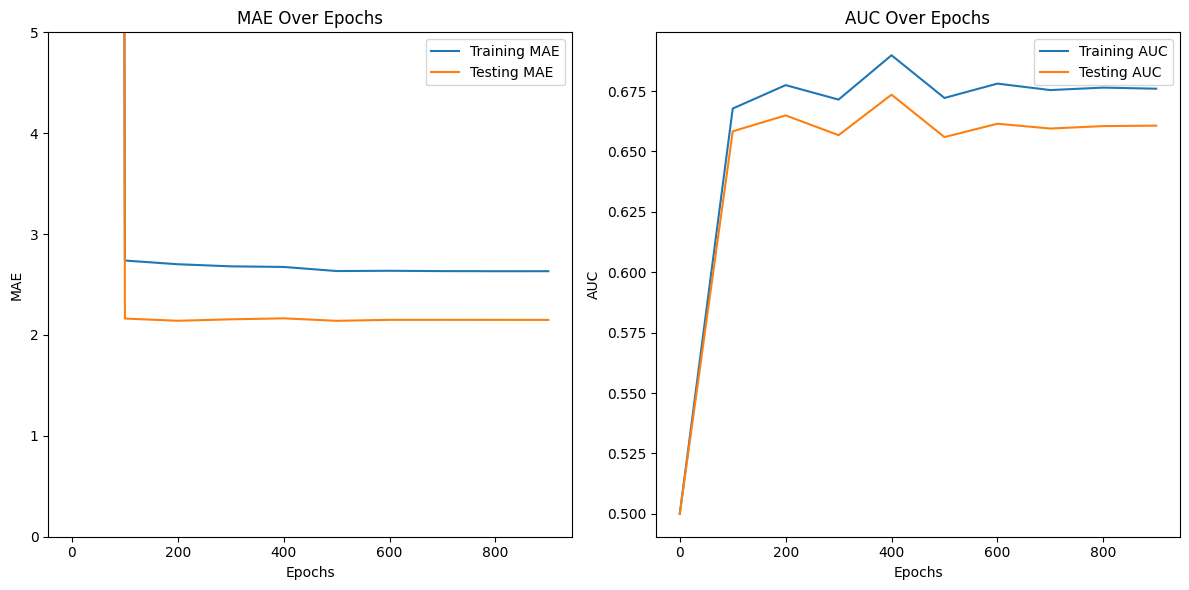

Test Regression MAE for class: 1.6701159477233887
Test Regression MAE: 2.1501071453094482
Test Classification AUC: 0.6606266281318185


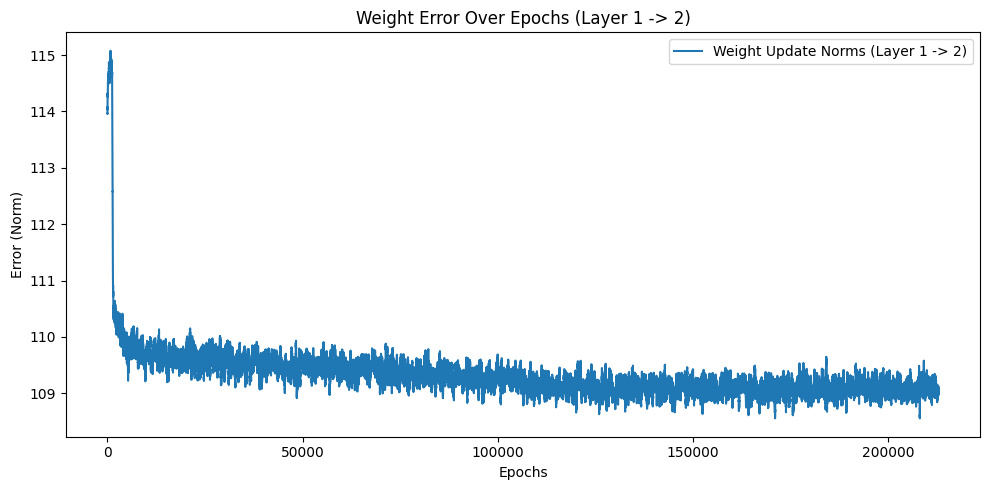

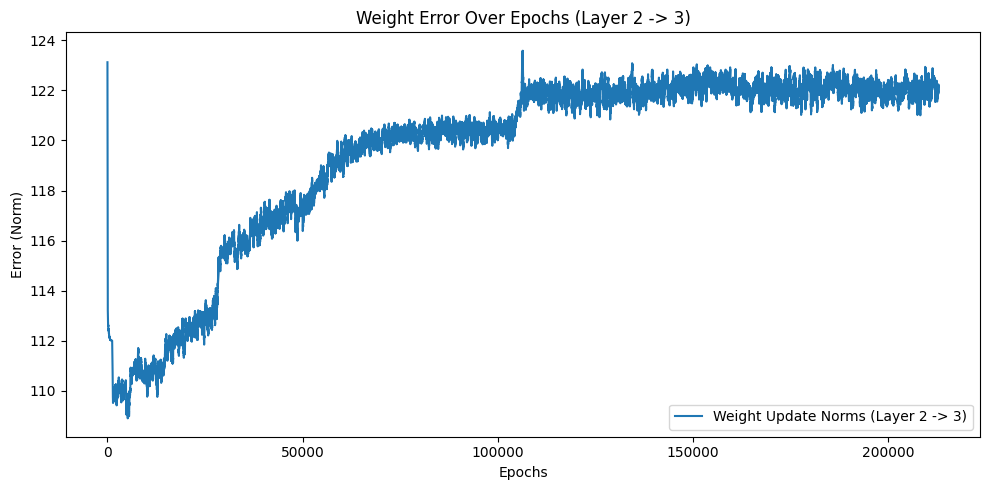

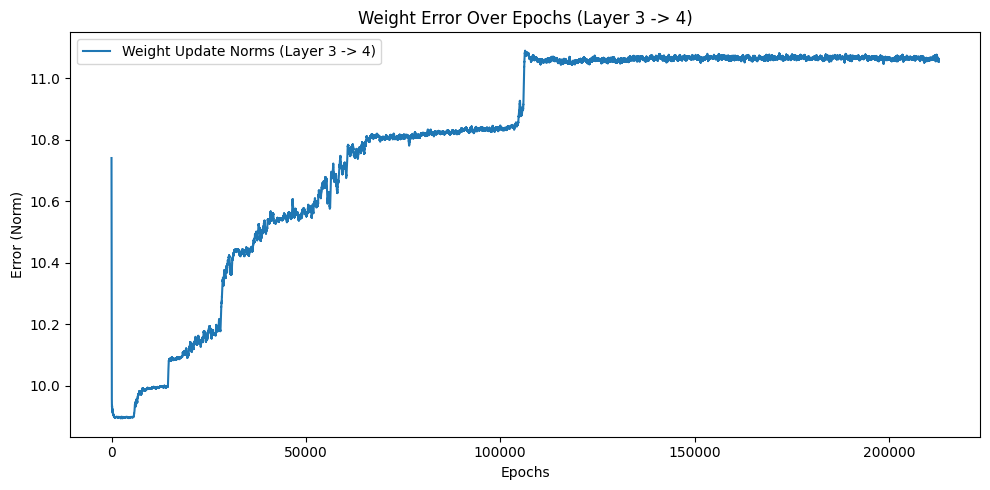

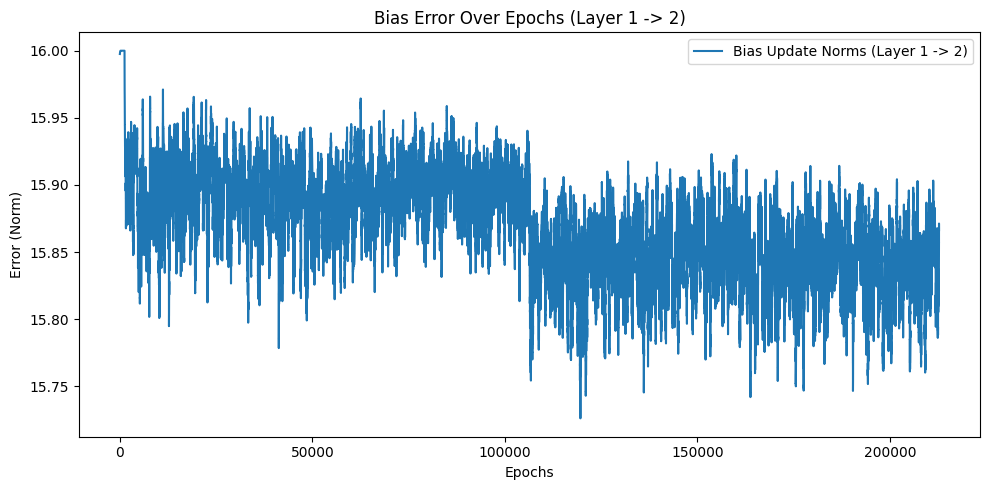

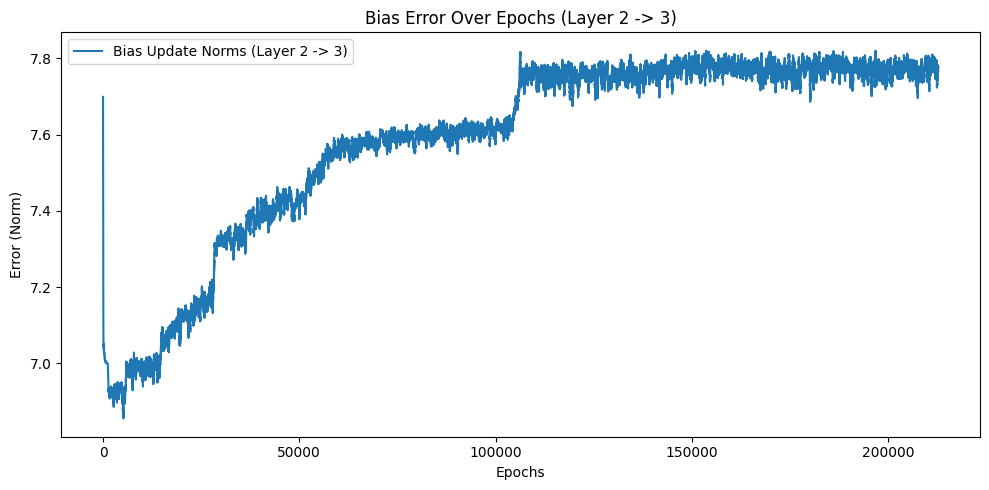

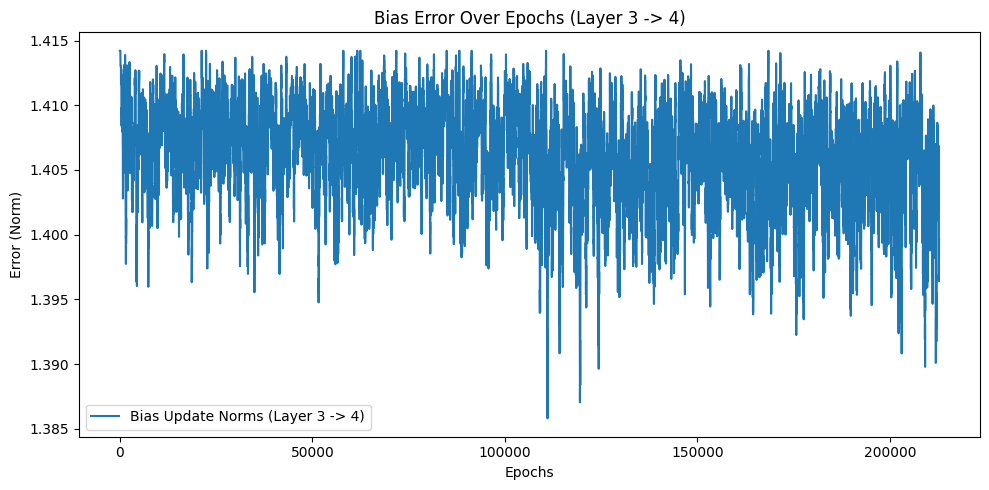

In [10]:
from weather_prediction import WeatherPredictionNetwork
# layers=[63, 256, 128, 2], activations=['sigmoid', 'relu'], learning_rate=0.0001, batch_size=256, epochs=1000
# layers = [X_train.shape[1] * X_train.shape[2], 512, 512, 2]
layers = [X_train.shape[1] * X_train.shape[2], 256, 128, 2]
activations = ["sigmoid", "relu"]
model = WeatherPredictionNetwork(layers, activations, binary_output=binary_output, seed=42)

if two_models:
    model2 = WeatherPredictionNetwork([X_train_2.shape[1], 64, 32, 2], ["linear", "linear"], binary_output=binary_output, seed=42)
    train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.0001, rate = [500, 750, 900], 
                    batch_size=245, binary_output=binary_output, 
                    model2=model2, X_train2=X_train_2, X_test2=X_test_2, y_train2=y_train_2, y_test2=y_test_2, 
                    X_2_std=X_2_std, X_2_mean=X_2_mean, standarize_2nd_data=standarize_2nd_data, add_noise=False)
else:
    # train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.0001, rate = [500, 750, 900], 
    #                 batch_size=245, binary_output=binary_output)
    train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.0001, rate = [500, 750, 900], 
                    batch_size=256, binary_output=binary_output)

In [11]:
from itertools import product
import cupy as cp
from sklearn.metrics import roc_auc_score

def hyperparameter_optimization(train_and_evaluate, X_train, y_train, X_test, y_test, binary_output):
    # Zakres hiperparametrów do optymalizacji
    layer_options = [
        [X_train.shape[1] * X_train.shape[2], 128, 64, 2],
    ]
    activation_options = [
        ["sigmoid", "relu"]
    ]
    learning_rate_options = [0.001, 0.0001]
    batch_size_options = [64, 128, 256, 512]
    epochs_options = [100, 200, 500, 1000, 1500, 2000]

    # Lista wszystkich kombinacji hiperparametrów
    search_space = list(product(layer_options, activation_options, learning_rate_options, batch_size_options, epochs_options))

    best_mae = float("inf")
    best_auc = 0
    best_params = None

    # Iteracja po wszystkich kombinacjach hiperparametrów
    for layers, activations, learning_rate, batch_size, epochs in search_space:
        print(f"Testing layers={layers}, activations={activations}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
        
        # Tworzenie modelu
        model = WeatherPredictionNetwork(layers, activations, binary_output=binary_output, seed=42)

        # Trening i ewaluacja
        mae, auc = train_and_evaluate(
            model, X_train, y_train, X_test, y_test,
            epochs=epochs, learning_rate=learning_rate, rate=[500, 750, 1000, 1500],
            batch_size=batch_size, binary_output=binary_output
        )

        # Aktualizacja najlepszych hiperparametrów
        if mae < best_mae or (mae == best_mae and auc > best_auc):
            best_mae = mae
            best_auc = auc
            best_params = (layers, activations, learning_rate, batch_size, epochs)

        print(f"Finished testing with MAE: {mae}, AUC: {auc}\n")

    print(f"Best params: layers={best_params[0]}, activations={best_params[1]}, learning_rate={best_params[2]}, batch_size={best_params[3]}, epochs={best_params[4]}")
    print(f"Best MAE: {best_mae}, Best AUC: {best_auc}")

    return best_params, best_mae, best_auc


In [12]:
# Best params: layers=[63, 128, 64, 2], activations=['sigmoid', 'relu'], learning_rate=0.0001, batch_size=256, epochs=1000
# Best MAE: 2.1387107372283936, Best AUC: 0.7361937317908783

# best_params, best_mae, best_auc = hyperparameter_optimization(
#     train_and_evaluate,
#     X_train, y_train,
#     X_test, y_test,
#     binary_output=binary_output
# )

In [13]:
# %pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args

def bayesian_optimization(train_and_evaluate, X_train, y_train, X_test, y_test, binary_output):
    # Przestrzeń wyszukiwania dla hiperparametrów
    space = [
        Categorical([
            (X_train.shape[1] * X_train.shape[2], 256, 128, 2),
            (X_train.shape[1] * X_train.shape[2], 512, 512, 2),
            (X_train.shape[1] * X_train.shape[2], 1024, 512, 2)
        ], name="layers"),
        Categorical([("sigmoid", "relu"), ("relu", "relu"), ("tanh", "relu")], name="activations"),
        Real(1e-4, 1e-2, prior="log-uniform", name="learning_rate"),
        Integer(32, 256, name="batch_size"),
        Integer(500, 1000, name="epochs")
    ]

    # Funkcja celu dla optymalizacji
    @use_named_args(space)
    def objective(layers, activations, learning_rate, batch_size, epochs):
        print(f"Testing: layers={layers}, activations={activations}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

        # Tworzenie modelu
        model = WeatherPredictionNetwork(list(layers), list(activations), binary_output=binary_output, seed=42)

        # Trening i ewaluacja
        mae, auc = train_and_evaluate(
            model, X_train, y_train, X_test, y_test,
            epochs=epochs, learning_rate=learning_rate, rate=[500, 750, 900],
            batch_size=batch_size, binary_output=binary_output
        )

        print(f"MAE: {mae}, AUC: {auc}")

        # Zwróć MAE jako wartość skalarną
        return float(mae)

    # Optymalizacja przy użyciu Bayesian Optimization
    result = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=20,  # Liczba iteracji optymalizacji
        random_state=42,
        verbose=True
    )

    # Najlepsze hiperparametry
    best_params = result.x
    print(f"Best parameters: layers={best_params[0]}, activations={best_params[1]}, learning_rate={best_params[2]}, batch_size={best_params[3]}, epochs={best_params[4]}")
    print(f"Best MAE: {result.fun}")

    return best_params, result.fun


In [14]:
# best_params, best_mae = bayesian_optimization(
#     train_and_evaluate,
#     X_train, y_train,
#     X_test, y_test,
#     binary_output=binary_output
# )

In [15]:
def compute_majority_class_percentage(y, binary_output=True):
    if binary_output:
        binary_labels = y[:, 1]
    else:
        binary_labels = y[:, 1] >=6
    
    unique, counts = np.unique(binary_labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    
    majority_class_count = max(class_counts.values())
    total_samples = len(binary_labels)
    majority_class_percentage = (majority_class_count / total_samples) * 100
    
    return majority_class_percentage, class_counts

majority_percentage_train, train_class_counts = compute_majority_class_percentage(y_train, binary_output=binary_output)
majority_percentage_test, test_class_counts = compute_majority_class_percentage(y_test, binary_output=binary_output)

print(f"Majority class percentage in training data: {majority_percentage_train:.2f}%")
print(f"Class distribution in training data: {train_class_counts}")
print(f"Majority class percentage in test data: {majority_percentage_test:.2f}%")
print(f"Class distribution in test data: {test_class_counts}")


Majority class percentage in training data: 56.02%
Class distribution in training data: {np.False_: np.int64(30444), np.True_: np.int64(23898)}
Majority class percentage in test data: 57.03%
Class distribution in test data: {np.False_: np.int64(7748), np.True_: np.int64(5838)}
